13장 합성곱 신경망
=========

- 13.1 시각 피질의 구조
- 13.2 합성곱층
    - 13.2.1 필터
    - 13.2.2 여러 개의 특성 맵 쌓기
    - 13.2.3 텐서플로 구현
    - 13.2.4 메모리 요구사항
- 13.3 풀링층
- 13.4 CNN 구조
    - 13.4.1 LeNet-5
    - 13.4.2 AlexNet
    - 13.4.3 GoogLeNet
    - 13.4.4 ResNet

기본설정

In [37]:
import numpy as np
import os
import matplotlib
import matplotlib.pyplot as plt

import tensorflow as tf 

def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)

matplotlib.rc('font', family='NanumBarunGothic')
plt.rcParams['axes.unicode_minus'] = False

In [38]:
## 텐서보드 쥬피터 안에 그리기
from IPython.display import clear_output, Image, display, HTML
import numpy as np    

def strip_consts(graph_def, max_const_size=32):
    """Strip large constant values from graph_def."""
    strip_def = tf.GraphDef()
    for n0 in graph_def.node:
        n = strip_def.node.add() 
        n.MergeFrom(n0)
        if n.op == 'Const':
            tensor = n.attr['value'].tensor
            size = len(tensor.tensor_content)
            if size > max_const_size:
                tensor.tensor_content = "<stripped %d bytes>"%size
    return strip_def

def show_graph(graph_def, max_const_size=32):
    """Visualize TensorFlow graph."""
    if hasattr(graph_def, 'as_graph_def'):
        graph_def = graph_def.as_graph_def()
    strip_def = strip_consts(graph_def, max_const_size=max_const_size)
    code = """
        <script>
          function load() {{
            document.getElementById("{id}").pbtxt = {data};
          }}
        </script>
        <link rel="import" href="https://tensorboard.appspot.com/tf-graph-basic.build.html" onload=load()>
        <div style="height:600px">
          <tf-graph-basic id="{id}"></tf-graph-basic>
        </div>
    """.format(data=repr(str(strip_def)), id='graph'+str(np.random.rand()))

    iframe = """
        <iframe seamless style="width:1200px;height:620px;border:0" srcdoc="{}"></iframe>
    """.format(code.replace('"', '&quot;'))
    display(HTML(iframe))

합성곱 신경망(convolutional neural network, CNN)은 대뇌의 시각 피질연구로부터 시작되었습니다. 이 기술은 많이 발전해서 이미지 검색, 서비스, 자율주행 자동차, 영상 자동 분류 시스템 등에 큰 기여를 했습니다. 또 시각 분야에 그치지 않고 음성 인식이나 자연어 처리 같은 다른 작업에도 많이 사용됩니다. 하지만 이 챕터에서는 시각적인 애플리케이션에 초점을 두고 공부하겠습니다.  

이 장에서는 CNN이 어디에서 왔는지, 구성 요소는 무엇인지, 텐서플로를 사용해 구현해보겠습니다. 또, 가장 뛰어난 성능의 CNN 구조 몇 개를 소개하겠습니다.

## 13.1 시각 피질의 구조

![a](.\images\Ch13fig1.png)

시각 피질 안의 많은 뉴런들은 작은 국부 수용장(local receptive field)을 가집니다. 뉴런들은 시야의 일부 범위 안에 있는 시각 자극에만 반응합니다. 뉴런의 수용장들이 서로 겹칠 수 있어 합치면 전체 시야를 감싸게 됩니다. 또, 어떤 뉴런은 수평선의 이미지에만 반응하고, 다른 뉴런은 다른 각도의 선분에 반응합니다.  거기에 더해 어떤 뉴런은 큰 수용장을 가져서 저수준 패턴이 조합되어 있는 더 복잡한 패턴에 반응합니다. 이러한 구조가 전체 시야 영역에 포함된 모든 종류의 복잡한 패턴을 감지할 수 있도록 합니다.   


합성곱 신경망이라고 부르는 것은 이런 시각 피질을 이용했습니다. CNN 구조에는 완전 연결 층과 시그모이드 활성화 함수 같은 구성 요소도 있지만, 합성곱층(convolution layer)과 풀릴층(pooling)이란 두 개의 새로운 구성 요소도 있습니다. 이 두 가지 구성 요소에 대해 살펴보도록 하겠습니다.

Note.  
완전 연결 층의 심층 신경망은 아주 많은 파라미터가 만들어지기 때문에 큰 이미지에는 적합하지 않습니다. 예를 들어 100 $\times$ 100 이미지에는 10000개의 픽셀로 이루어져있습니다. 여기에 첫 번째 은닉층을 1000개의 뉴런으로만 만들어도 $10^7$개의 연결이 생깁니다.

## 13.2 합성곱층

![a](.\images\Ch13fig2.png)

CNN의 가장 중요한 구성 요소는 합성곱층(convolutional layer)입니다. 첫 번째 합성곱층의 뉴런은 합성곱층 뉴런의 수용장 안에 있는 픽셀에만 연결됩니다. 두 번째 합성곱층에 있는 각 뉴런은 첫 번째 층의 작은 사각 영역 안에 위치한 뉴런에 연결됩니다. 이런 구조는 네트워크가 첫 번쨰 은닉층에서는 저수준 특성에 집중하고, 그다음 은닉층에서는 고수준 특성으로 조합해 나가도록 도와줍니다.

![a](.\images\Ch13fig3.png)

일반적으로 CNN에서 은닉층의 크기는 전 은닉층의 크기와 같거나 작습니다. 지금 예시에서는 같은 경우라고 생각해보겠습니다. 어떤 층의 $i$행, $j$열에 있는 한 뉴런은 이전 층의 $i-(f_h-1)/2$부터 $i+(f_h-1)/2$까지의 행과 $i-(f_w-1)/2$부터 $i-(f_w-1)/2$까지의 열에 있는 뉴런의 출력에 연결됩니다. 그림에서와 같이 높이와 너비를 이전 층과 같게 하기 위해서 주위에 0을 추가하는 것이 일반적입니다. 이를 제로 패딩(zero padding)이라고 합니다.

![a](.\images\Ch13fig4.png)

- 위에 그림에서처럼 수용장 사이에 간격을 두어 큰 입력층을 훨씬 작은 층에 연결하는 것도 가능합니다. 연속된 두 개의 수용장 사이의 거리를 **스트라이드**라고 합니다.  이 그림에서는 $5 \times 7$ 입력층이 $3 \times 3$ 수용장과 스트라이드 $2$를 사용하여 $3 \times 4$층에 연결되었습니다. 
- 상위층의 $i$행, $j$열에 있는 뉴런이 이전 층의 $i\times s_h +(f_h - 1)/2$부터 $i\times s_h+(f_h - 1)/2$까지의 행과  $i\times s_w +(f_w - 1)/2$부터 $i\times s_w+(f_w - 1)/2$까지의 열에 위치한 뉴런과 연결됩니다.
- 여기서 $s_h$와 $s_w$는 스트라이드의 수직 값과 수평 값입니다.

### 13.2.1 필터

- 수직 필터
![a](.\images\Ch13fig6.png)


<br><br>
- 수평 필터
![a](.\images\Ch13fig7.png)

뉴런의 가중치는 수용장 크기의 작은 이미지로 표현될 수 있습니다. 뉴런에게 필터(filter) 또는 합성곱 커널(convolution kernel)라 부르는 가중치를 부여할 수 있습니다. 예를 들어 위에 있는 필터들은 가운데 열은 1로 채워져 있고 그 외에는 모두 0인 필터입니다. 이런 가중치를 사용한 뉴런은 가운데 부분을 제외하고는 수용장에 있는 모든 것을 무시합니다.

**\*참고**
![a](.\images\Ch13fig8.png)
- 예를 들어, 4 $\times$ 3 입력층에 3 $\times$ 3 수용장과 스트라이드 1을 사용하여 연결하면 (다른 가중치는 다 1이라고 가정할 때) 오른쪽 결과 값이 나옵니다.

![a](.\images\Ch13fig5.png)

입력 이미지를 네트워크에 주입하고 한 층의 모든 뉴런에 같은 수직선 필터를 적용하면 이 층은 왼쪽 위의 이미지를 출력할 것입니다. 수직선은 강조되고 나머지는 희미해졌습니다. 비슷하게 오른쪽 위의 이미지는 모든 뉴런에 수평선 필터를 적용했을 때 얻은 것입니다. 같은 필터를 사용한 뉴런의 층은 필터와 유사한 이미지의 영역을 강조하는 특성 맵(feature map)을 만듭니다. 훈련 과정에서 CNN은 해당 문제에 가장 유용한 필터를 찾고 이들을 연결하여 더 복잡한 패턴을 학습합니다.

### 13.2.2 여러 개의 특성 맵 쌓기

합성곱층은 사실 같은 크기의 여러 개의 특성 맵으로 구성되어 있어서 3D로 표현하는 것이 정확합니다.

![a](.\images\Ch13fig9.png)

하나의 특성 맵 안에서는 모든 뉴런이 같은 파라미터를 공유하지만, 다른 특성 맵은 다른 파라미터를 가집니다.

Note.  
CNN이 한 지점에서 패턴을 인식하도록 학습되었다면 다른 어느 위치에 있더라도 패턴을 인식할 수 있습니다. DNN은 한 지점에 있는 패턴을 인식하도록 학습되었어도 오직 패턴이 그 위치에 있을 때만 감지할 수 있습니다.

또 입력 이미지는 컬러 채널마다 하나씩 여러 개의 서브층으로 구성되기도 합니다.

- 식 13 -1

$$
z_{i,j,k} = b_k + \sum^{\frac{f_h - 1}{2}}_{u=-\frac{f_h - 1}{2}}\sum^{\frac{f_w - 1}{2}}_{v=-\frac{f_w - 1}{2}}\sum^{f_{n'} - 1}_{k'=0}x_{i',j',k'}\times w_{u,v',k',k} \\ \text{ where } 
\begin{cases}
i' &= i \times s_h + u \\
j' &= j \times s_w + v
\end{cases}
$$
- $z_{i,j,k}$는 합성곱층($l$ 층)의 $k$ 특성 맵에서 $i$행, $j$열에 위치한 뉴런의 출력입니다.
- 앞서 설명한 것처럼 $s_h$와 $s_w$는 수직과 수평 스트라이드이고 $f_h$와 $f_w$는 수용장의 높이와 너비입니다. 그리고 $f_{n'}$은 이전 층($l -1$ 층)에 있는 특성 맵의 수입니다.
- $x_{i',j',k'}$는 $l-1$ 층의 $i'$행, $j'$열, $k '$ 특성 맵(혹은 $l-1$ 층이 입력층이면 $k'$ 채널)에 있는 뉴런의 출력입니다.
- $b_k$는 ($l$ 레이어에 있는) $k$ 특성 맵의 편향입니다.
- $w_{u,v,k',k}$는 $l$층의 $k$ 특성 맵에 있는 모든 뉴런과 (뉴런의 수용장에 연관된) $u$행, $v$열, 그리고 $k'$ 특성 맵위에 위치한 입력 사이의 연결 가중치입니다.

### 13.2.3 텐서플로 구현

텐서플로에서 각 입력 이미지는 보통 [높이, 너비, 채널] 형태의 3D 텐서로 표현됩니다. 하나의 미니배치는 [미니배치 크기, 높이, 너비, 채널] 형태의 4D 텐서로 표현됩니다. 합성곱층의 가중치는 [$f_n$, $f_w$, $f_{n'}$, $f_n$] 형태의 4D 텐서로 표현됩니다. 합성곱층의 편향은 간단하게 [$f_n$] 형태의 1D 텐서로 나타냅니다.   
예제로 살펴보도록 하겠습니다.

In [40]:
from sklearn.datasets import load_sample_image

# 샘플 이미지를 로드
china = load_sample_image("china.jpg")
flower = load_sample_image("flower.jpg")
dataset = np.array([china, flower], dtype=np.float32)
batch_size, height, width, channels = dataset.shape

In [41]:
china.shape # height, width, channel

(427, 640, 3)

In [43]:
flower.shape # height, width, channel

(427, 640, 3)

(2, 214, 320, 2)


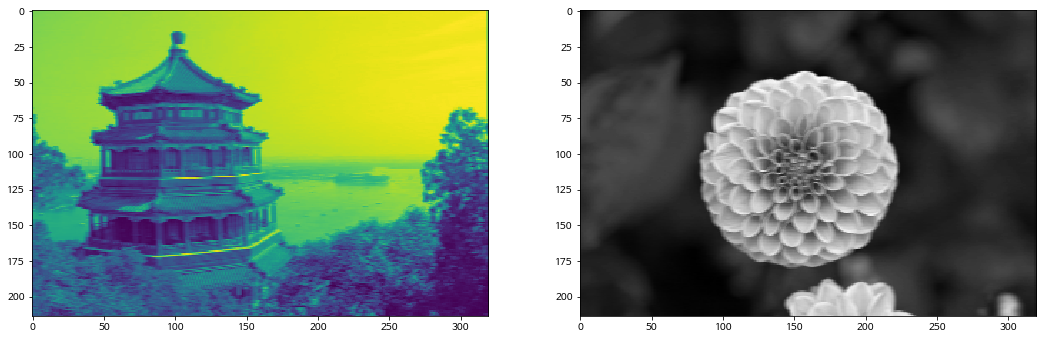

In [45]:
# 2개의 필터를 만듭니다.
filters = np.zeros(shape=(7, 7, channels, 2), dtype=np.float32)
filters[:, 3, :, 0] = 1 # 수직선
filters[3, :, :, 1] = 1 # 수평선

# 입력 X와 2개의 필터를 적용한 합성곱층의 그래프를 만듭니다.
X = tf.placeholder(tf.float32, shape=(None, height, width, channels))
convolution = tf.nn.conv2d(X, filters, strides=[1, 2, 2, 1], padding='SAME')
## 밑에서 자세하게 설명 ㄱㄱ

with tf.Session() as sess:
    output = sess.run(convolution, feed_dict={X: dataset})

print(output.shape)  #(2, 214, 320, 2), 사진, 특성, 특성, 필터
    
plt.figure(figsize=(18,15))
    
plt.subplot(121)
plt.imshow(output[0, :, :, 1], cmap="gray") 

plt.subplot(122)
plt.imshow(output[1, :, :, 1], cmap="gray") 
plt.show()

tf.nn.conv2d( )를 자세하게 뜯어보겠습니다.
- X는 입력의 미니배치(4D 텐서)
- filters는 적용될 일련의 필터(4D 텐서)
- strides는 4개의 원소를 갖는 1D 배열. 
    - 가운데 두 개의 원소는 수직, 수평 스트라이드(s_h와 s_w)
    - 첫 번째 원소는 배치 스트라이드 
    - 네 번째 스트라이드는 채널 스트라이드
- padding은 "VALID"와 "SAME" 중 하나
    - "VALID"로 지정하면 합성곱층에 제로 패딩을 사용하지 않습니다.
    - "SAME"으로 지정하면 합성곱층에 제로 패딩을 사용합니다. 이 경우 출력 뉴런 수는 입력 뉴런 수를 스트라이드로 나누어 올림 한 것과 같습니다(여기서 ceil(13/5) = 3). 그리고 입력 데이터 주변에 가능한 동일하게 0이 추가됩니다.
        - 그림으로 보겠습니다

![a](.\images\Ch13fig10.png)
이처럼 "VALID"는 수용자의 끝이 입력값의 끝에 닿으면 다음 뉴런을 만들지 않습니다.

이 예에서는 수동으로 필터를 만들었지만, 실제 CNN에서는 훈련 알고리즘이 최선의 필터를 자동으로 탐색합니다. 텐서플로에는 필터 변수를 (kernel이란 이름으로) 만들고 랜덤하게 초기화 해주는 tf.layers.conv2d( ) 함수가 있습니다. 또한 편향 변수를 (bias란 이름으로) 만들고 0으로 초기화합니다.

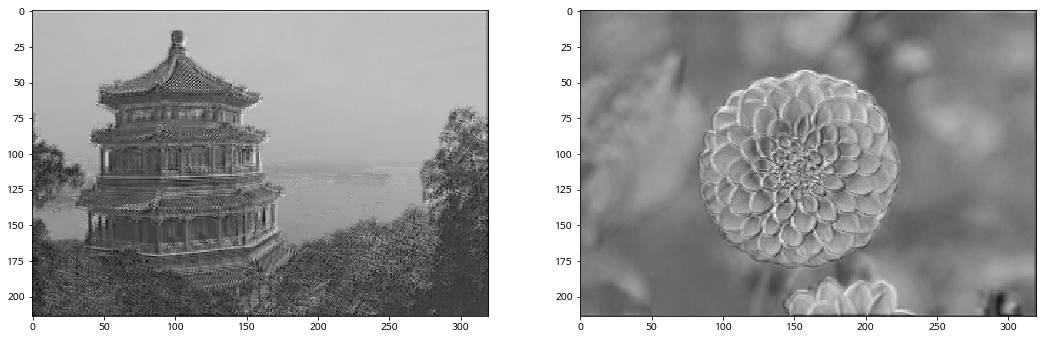

In [55]:
reset_graph()

X = tf.placeholder(shape=(None, height, width, channels), dtype=tf.float32)
conv = tf.layers.conv2d(X, filters=2, kernel_size=7, strides=[2, 2],
                       padding="SAME")

init = tf.global_variables_initializer() ## filter 값을 업데이트해야하기 때문에(즉, filter값이 변수임)

with tf.Session() as sess:
    init.run()
    output = sess.run(conv, feed_dict={X: dataset})

plt.figure(figsize=(18,15))

plt.subplot(121)
plt.imshow(output[0, :, :, 1], cmap="gray")

plt.subplot(122)
plt.imshow(output[1, :, :, 1], cmap="gray") 

plt.show()

In [56]:
output[0, :, :, 1]

array([[177.00418  , 205.59114  , 206.2586   , ..., 243.47163  ,
        222.64905  , 133.63342  ],
       [213.6389   , 210.08423  , 209.17584  , ..., 219.20421  ,
        134.83157  , 108.76114  ],
       [230.75223  , 182.70776  , 184.5722   , ..., 193.34755  ,
        116.55554  ,  19.168762 ],
       ...,
       [  1.7047092, -32.715897 ,   5.8686213, ...,  23.254318 ,
         10.894764 ,  -1.026083 ],
       [ 34.931458 , -38.725372 , -24.529388 , ...,   1.3261127,
        -10.706657 ,  -6.3752823],
       [-14.235055 , -45.24553  , -52.713856 , ...,  21.888247 ,
         -5.0840263, -17.084316 ]], dtype=float32)

여기에도 많은 하이퍼파라미터가 있고 적절한 하이퍼파라미터 값을 찾아야하지만 뒤에 살펴볼 CNN 구조들을 살펴보면 실전에서 어떤 하이퍼파라미터 값이 잘 작동하는지 알 수 있습니다.

### 13.2.4 메모리 요구사항

CNN에 관련된 하나의 문제는 역전파 알고리즘이 역방향 계산을 할 때 정방향에서 계산했던 모든 중간 값을 필요로 하기 때문에 훈련하는 동안에 많은 양의 RAM이 필요합니다.   
추론을 할 때는 하나의 층이 점유하고 있는 RAM은 다음 층의 계산이 완료되자마자 해제할 수 있지만, 훈련하는 동안에는 정방향에서 계산했던 모든 값이 역방향을 위해 보존되어야 합니다.

## 13.3 풀링층

![a](.\images\Ch13fig11.png)

풀링층(pooling layer)의 목적은 계산량과 메모리 사용량, 그리고 (결과적으로 과대적합의 위험을 줄여주는) 파라미터 수를 줄이기 위해 입력 이미지의 부표본(subsample) 즉, 축소본을 만드는 것입니다.   
풀링층의 각 뉴런은 이전 층의 작은 사각 영역의 수용장 안에 있는 뉴런의 출력과 연결되어 있습니다. 이전과 동일하게 크기, 스트라이드, 패딩 유형을 지정해야 합니다. 하지만 풀링 뉴런은 가중치가 없습니다. 최대나 평균 같은 합산 함수를 사용해 입력값을 더하는 것이 전부입니다.

![a](.\images\Ch13fig12.png)

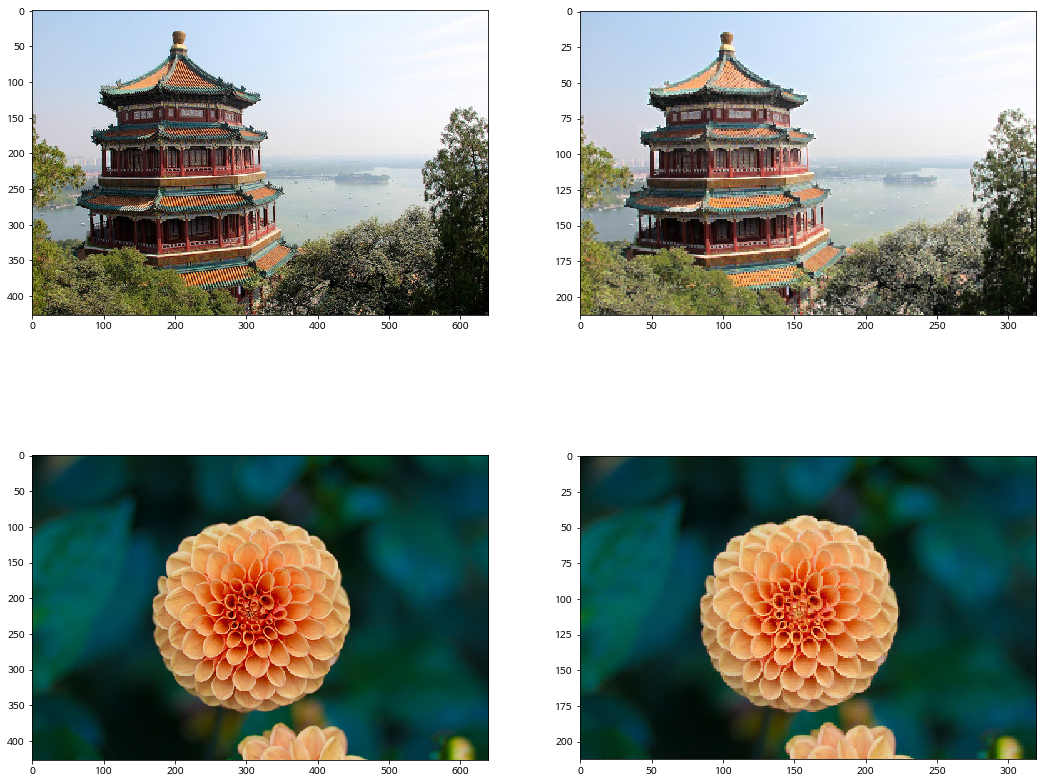

왼쪽이 풀링 전, 오른쪽이 풀링 후


In [81]:
reset_graph()

X = tf.placeholder(tf.float32, shape=(None, height, width, channels))
max_pool = tf.nn.max_pool(X, ksize=[1,2,2,1], strides=[1,2,2,1],padding="VALID")

with tf.Session() as sess:
    output1 = sess.run(max_pool, feed_dict={X: dataset})
    
plt.figure(figsize=(18,15))

plt.subplot(221)
plt.imshow(dataset[0].astype(np.uint8))

plt.subplot(222)
plt.imshow(output1[0].astype(np.uint8)) 
#그림을 그리려면 색 데이터는 0~1까지거나 0~255 사이의 값이여야 하는데
# 지금은 float 자료형이여서 int로 바꿔줘야함.
# 실제 훈련에서는 이 부분에서 그림을 그리지 않으니 np.uint8는 신경쓰지 않아도 됨

plt.subplot(223)
plt.imshow(dataset[1].astype(np.uint8))

plt.subplot(224)
plt.imshow(output1[1].astype(np.uint8))
plt.show()

print("왼쪽이 풀링 전, 오른쪽이 풀링 후")

- ksize는 커널의 사이즈입니다.
    - 텐서플로는 미니배치의 크기를 줄이는 풀링은 할 수 없습니다. 따라서 ksize의 첫 번째 원소는 1이어야 합니다.
    
- 평균 풀링층을 만들기 위해서는 max_pool( ) 함수 대신 avg_pool( ) 함수를 사용하면 됩니다.

## 13.4 CNN 구조

![a](.\images\Ch13fig11.png)

전형적인 CNN 구조
- input
   
   
- 합성곱층 + ReLU 층
- 풀링층


- 합성곱층 + ReLU 층
- 풀링층


        - ...반복...
        
        
- 몇 개의 완전 연결 층 + ReLU 층


- 마지막 층에서 예측을 출력   

Note.  
합성곱층에 너무 큰 커널을 사용하지 않아도 됩니다. 3 $\times$ 3 커널 두 개를 이어서 5 $\times$ 5 커널과 같은 효과를 낼 수 있습니다. 파라미터 계산량도 적습니다.

### 13.4.1 LeNet-5

LeNet-5 구조는 1998년에 만들어졌고, 가장 널리 알려진 CNN 구조입니다. 이 구조는 손글씨 숫자 인식(MNIST)에 널리 사용되었고, 다음과 같은 층으로 구성되어 있습니다.

층| 종류| 특성 맵| 크기| 커널 크기| 스트라이드| 활성화 함수
----|----|----|-----|-----|-----|-----
출력|완전 연결|-|10|-|-|RBF
F6|완전 연결|-|84| -| -|tanh
C5|합성곱| 120| 1$\times$ 1| 5$\times $5| 1|tanh
S4| 평균 풀링|16|5$\times $5| 2$\times $2| 2| tanh
C3|합성곱| 16 | 10$ \times $10 | 5$\times $5| 1|tanh
S2| 평균 풀링|6|14$\times $14| 2$\times $2| 2| tanh
C1 | 합성곱| 6 | 28$ \times $28| 5$\times $5| 1|tanh
입력| 입력| 1| 32$ \times $32| -| - | -


- MNIST 이미지는 28 $\times$ 28 픽셀이지만 제로 패딩되어 32 $\times$ 32가 되고 네트워크에 주입되기 전에 정규화됩니다. 네트워크의 나머지 부분은 패딩을 사용하지 않습니다.
- 평균 풀링층의 각 뉴런은 입력의 평균을 계싼한 다음, 그 값에 학습되는 계숫값을 곱하고 학습되는 값인 편향을 더합니다. 그리고 활성화 함수를 적용합니다.
- C3에 있는 대부분의 뉴런은 S2의 3개 또는 4개 맵에 있는 뉴런에만 연결됩니다.
- 출력층은 입력 벡터와 가중치 벡터 사이의 유클리디안 거리를 출력하고, 이미지가 얼마나 특정 숫자 클래스에 속하는지 측정합니다.

In [17]:
reset_graph()

from tensorflow.examples.tutorials.mnist import input_data

mnist = input_data.read_data_sets("MNIST_data", one_hot=True)

x = tf.placeholder("float", shape=[None, 784])
y_ = tf.placeholder("float", shape=[None, 10])

x_image = tf.reshape(x, [-1, 28, 28, 1])

Extracting MNIST_data\train-images-idx3-ubyte.gz
Extracting MNIST_data\train-labels-idx1-ubyte.gz
Extracting MNIST_data\t10k-images-idx3-ubyte.gz
Extracting MNIST_data\t10k-labels-idx1-ubyte.gz


가중치를 표준편차 0.1을 갖는 난수로 초기화하는 함수와 바이어스를 0.1로 초기화하는 함수를 정의합니다.

In [18]:
def weight_variable(shape):
    initial = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(initial)

def bias_variable(shape):
    initial = tf.constant(0.1, shape=shape)
    return tf.Variable(initial)

stride는 1로 하고 패딩은 0으로 하는 합성곱층을 만드는 함수와 2 $\times$ 2 평균 풀링 레이어를 위한 함수를 정의합니다.

In [19]:
def conv2d(x, W, padding="VALID"):
    return tf.nn.conv2d(x, W, strides=[1,1,1,1], padding=padding)

def avg_pool_2x2(x):
    return tf.nn.avg_pool(x, ksize=[1,2,2,1], strides=[1,2,2,1], padding="VALID")

첫 번째 합성곱층을 만들기 위해 가중치와 바이어스 텐서를 만들고, 활성화함수는 tanh 함수를 사용합니다. 그리고 합성곱층 뒤에 평균 풀링층을 추가합니다.

In [20]:
W_conv1 = weight_variable([5,5,1,6]) ## 수용장  너비, 수용장 높이, 컬러, 특성 맵 개수
b_conv1 = bias_variable([6])

h_conv1 = tf.nn.tanh(conv2d(x_image, W_conv1,padding="SAME") + b_conv1)
h_pool1 = avg_pool_2x2(h_conv1)

두 번째 합성곱층을 만들기 위해 가중치와 바이어스 텐서를 만들고, 활성화함수는 tanh 함수를 사용합니다. 그리고 합성곱층 뒤에 평균 풀링층을 추가합니다.

In [21]:
W_conv2 = weight_variable([5,5,6,16]) ## 수용장  너비, 수용장 높이, 컬러, 특성 맵 개수
b_conv2 = bias_variable([16])

h_conv2 = tf.nn.tanh(conv2d(h_pool1, W_conv2) + b_conv2)
h_pool2 = avg_pool_2x2(h_conv2)

세 번째 합성곱층을 만들기 위해 가중치와 바이어스 텐서를 만듭니다.

In [22]:
W_conv3 = weight_variable([5,5,16,120]) ## 수용장  너비, 수용장 높이, 컬러, 특성 맵 개수
b_conv3 = bias_variable([120])

h_conv3 = tf.nn.tanh(conv2d(h_pool2, W_conv3) + b_conv3)

In [23]:
h_conv3.get_shape()

TensorShape([Dimension(None), Dimension(1), Dimension(1), Dimension(120)])

RBF 층에 연결하기 위해 완전연결 층을 추가합니다. 이전 합성곱층의 결과를 1차원 텐서로 변환하여 tanh 활성화함수에 전달합니다.

In [25]:
W_fc1 = weight_variable([1 * 1 * 120, 84]) ## 84는 뉴런 개수
b_fc1 = bias_variable([84])

h_conv3_flat = tf.reshape(h_conv3, [-1, 1 * 1 * 120])
h_fc1 = tf.nn.tanh(tf.matmul(h_conv3_flat, W_fc1) + b_fc1)

마지막으로 RBF 층 레이어를 추가해야하지만, 어떻게 하는지 몰라서 제 맘대로 하겠습니다.

In [28]:
W_fc2 = weight_variable([84, 10])
b_fc2 = bias_variable([10])

logits = tf.matmul(h_fc1, W_fc2) + b_fc2

이제 비용함수를 정의하고 최적화알고리즘, 평가를 위한 연산을 정의하겠습니다.

In [32]:
cross_entropy = tf.nn.softmax_cross_entropy_with_logits_v2(labels=y_, logits=logits)
loss_operation = tf.reduce_mean(cross_entropy)

optimizer = tf.train.AdamOptimizer(learning_rate=0.001)
train_step = optimizer.minimize(loss_operation)

correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(y_, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))

이제 훈련시켜보겠습니다. 오래걸려요...

In [37]:
init = tf.global_variables_initializer()

with tf.Session() as sess:
    init.run()
    for i in range(20000):
        batch = mnist.train.next_batch(50)
        if i % 1000 == 0:
            train_accuracy = sess.run(accuracy, feed_dict={
                x:batch[0], y_: batch[1]
            })
            print("step %d, training accuracy %g" %(i, train_accuracy))
        sess.run(train_step, feed_dict={x: batch[0], y_: batch[1]})
        
    ## 최종결과
    print("test accuracy %g" % sess.run(
            accuracy, feed_dict={x: mnist.test.images, y_: mnist.test.labels}))

step 0, training accuracy 0.06
step 1000, training accuracy 0.9
step 2000, training accuracy 0.98
step 3000, training accuracy 0.98
step 4000, training accuracy 0.98
step 5000, training accuracy 1
step 6000, training accuracy 1
step 7000, training accuracy 1
step 8000, training accuracy 1
step 9000, training accuracy 1
step 10000, training accuracy 1
step 11000, training accuracy 1
step 12000, training accuracy 1
step 13000, training accuracy 0.98
step 14000, training accuracy 1
step 15000, training accuracy 1
step 16000, training accuracy 0.98
step 17000, training accuracy 1
step 18000, training accuracy 1
step 19000, training accuracy 1
test accuracy 0.9875


### 13.4.2 AlexNet

AlexNet CNN 구조는 2012년 이미지넷 대회에서 우승을 차지했습니다. 이 구조는 더 크고 깊을 뿐 LeNet-5와 매우 비슷하며, 처음으로 합성곱층 위에 풀링층을 쌓지 않고 바로 합성곱층끼리 쌓았습니다.

층| 종류| 특성 맵| 크기| 커널 크기| 스트라이드|패딩| 활성화 함수
----|----|----|-----|-----|-----|-----|--
출력|완전 연결|-|1000|-|-|-|Softmax
F9|완전 연결|-|4096| -|-|-|ReLu
F8|완전 연결|-|4096| -|-|-|ReLu
C7|합성곱| 256| 13$\times$ 13| 3$\times $3| 1|SAME|ReLU
C6|합성곱| 384| 13$\times$ 13| 3$\times $3| 1|SAME|ReLU
C5|합성곱| 384| 13$\times$ 13| 3$\times $3| 1|SAME|ReLU
S4| 최대 풀링|256|13$\times$ 13| 3$\times $3| 2| VALID|-
C3|합성곱| 256| 27$ \times $27 | 5$\times $5| 1|SAME|ReLU
S2| 최대 풀링|96|27$\times $27| 3$\times $3| 2| VALID|-
C1 | 합성곱| 96 | 55$ \times $55| 11$\times $11| 4|SAME|ReLU
입력| 입력| 3(RGB)| 224$ \times $224| -| - | -|-


과대적합을 줄이기 위해 저자들은 두 가지 규제 기법을 사용했습니다.
1. 훈련하는 동안 F8과 F9의 출력에 드롭아웃(50% 드랍아웃 비율)을 적용했습니다.
2. 훈련 이미지를 랜덤하게 여러 간격으로 이동하거나 수평으로 뒤집고 조명을 바꾸는 식으로 데이터 증식을 수행했습니다.  


AlexNet은 C1과 C3 층의 ReLU 단계 후에 바로 LRN(local response normalization)이라 부르는 정규화 단계를 사용했습니다. 이 정규화는 가장 강하게 활성화된 뉴런이 다른 특성 맵에 있는 같은 위치의 뉴런을 억제하는 형태입니다(생물학적 뉴런에서 관측된 모습입니다).

식 13-2 LRN  
$$
b_i = a_i (k + \alpha \sum^{j_{high}}_{j=j_{low}}a_j^2)^{-\beta} \text{ where }
\begin{cases}
j_{} &= min(i + \frac{}{}, f_n -1) \\
j_{} &= max(0, i - \frac{r}{2})
\end{cases}
$$
- $b_i$는 $i$ 특성 맵, $u$ 행, $v$ 열에 위치한 뉴런의 정규화된 출력입니다(이 식에서는 현재의 행과 열에 위치한 뉴런만 고려하므로 $u$와 $v$는 없습니다).
- $a_i$는 ReLU 단계를 지나고 정규화 단계를 거치기 전인 뉴런의 활성화 값입니다.
- $k$, $\alpha$, $\beta$, $r$는 하이퍼파라미터입니다. $k$는 편향, $r$은 깊이 반경입니다.
- $f_n$은 특성 맵의 수입니다.

AlexNet에서 하이퍼파라미터는 $r = 2$, $\alpha = 0.00002$, $\beta = 0.75$, $k = 1$로 설정되었습니다. 이 단계는 텐서플로의 tf.nn.local_response_normalization( ) 연산을 사용하여 구현할 수 있습니다. 

### 13.4.3 GoogLeNet

GoogLeNet 구조는 인셉션 모듈이라는 서브 네트워크를 가지고 있어서 GoogLeNet이 이전의 구조보다 훨씬 효과적으로 파라미터를 사용합니다. 실제로 GoogLeNet은 AlexNet보다 10배나 적은 파라미터를 가집니다

![a](.\images\Ch13fig13.png)

여기서 3$\times$3 + 1(S)는 3$\times $3 커널, 스트라이드 1, SAME 패딩을 사용한다는 뜻입니다. 처음 신호가 복사되어 네 개의 다른 층에 주입됩니다. 모든 합성곱층은 ReLU 활성화 함수를 사용합니다. 두 번째 합성곱층은 각기 다른 커널 크기(1 $\times$ 1, 3$\times$ 3, 5$\times$ 5)를 사용하여 다른 크기의 패턴을 잡습니다. 모든 층은 스트라이드 1과 SAME 패딩을 사용하므로 출력의 높이와 너비가 모두 입력과 같습니다. 이 다음 출력을 깊이 연결 층(Depth Concat Layer)에서 특성 맵 쌓듯이 쌓을 수 있습니다. 이 연결 층은 텐서플로의 axis=3 매개변수로 tf.concat( ) 연산을 사용하여 구현할 수 있습니다.  


인셉션 모듈에서 1 \times 1 커널의 합성곱층은 두 개의 목적을 가지고 있습니다.
- 입력의 채널보다 더 적은 특성 맵을 출력합니다. 차원을 줄이는 효과를 볼 수 있습니다. 
- 합성곱층의 쌍([1 $\times$ 1, 3 $\times$ 3]과 [1 $\times$ 1, 5 $\times$ 5])이 복잡한 패턴을 감지할 수 있는 한 개의 합성곱층처럼 작동합니다.


Note.  
각 합석곱층의 합성곱 커널의 수는 하이퍼파라미터입니다. 인셉션 모듈을 추가하면 6개의 하이퍼파라미터를 조율해야 합니다.  


이제 GoogLeNet CNN의 구조를 살펴보겠습니다.

![a](.\images\Ch13fig14.png)

- 합성곱층과 풀링층에서 출력되는 특성 맵의 수는 앞에 있는 숫자입니다.
- 인셉션 모듈에 있는 숫자는 합성곱층에서 출력하는 특성 맵의 수입니다.
- 합성곱층은 ReLU 활성화 함수를 사용합니다.


이제 이 네트워크를 살펴보겠습니다.
- 처음 두 층은 계산의 양을 줄이기 위해 만든 층입니다.
- LRN 층은 여기서도 쓰입니다(다양한 특성을 학습하도록 합니다).
- 이어지는 두 개의 합성곱층은 병목층처럼 작용합니다(차원을 줄인다는 이야기입니다).
- 다시 한번 LRN 층을 씁니다.
- 그다음 최대 풀링층이 이미지의 높이와 너비를 줄입니다.
- 9개의 인셉션 모듈이 이어지고, 차원 감소와 속도 향상을 위해 최대 풀링층을 몇개 넣어놓습니다.
- 그다음에 평균 폴링층이 특성 맴 크기의 커널을 VALID 패딩으로 적용해 1 $\times$ 1 특성 맵을 출력합니다. 이런 전략을 전역 평균 폴링이라고 합니다. 이 층은 CNN 위에 여러 개의 완전 연결 층을 놓는 것을 불필요하게 만들므로 네트워크의 파라미터 수를 많이 줄여주고 과대적합의 위험을 줄여줍니다.
- 규제를 위한 드롭아웃과 클래스 확률 추정 값을 출력하기 위한 소프트맥스 활성화 함수를 적용한 완전 연결 층입니다.

### 13.4.4 ResNet

다음 중요한 구조는 잔차 네트워크(Residual Network), ResNet입니다. 이 구조의 핵심 요소는 스킵 연결, skip connection(또는 숏컷 연결, shortcut connection)입니다. 이는 어떤 층에 주입되는 신호가 상위층의 출력에도 더해지는 것입니다.  
![a](.\images\Ch13fig15.png)

신경망을 훈련시킬 때는 목적 함수 $h(x)$를 모델링하는 것이 목표입니다. 만약 입력 $x$를 네트워크의 출력에 더한다면(즉, 스킵 연결을 추가하면) 네트워크는 $h(x)$ 대신 $f(x) = h(x) - x$를 학습하게 될 것입니다. 이를 잔차 학습, residual learning이라고 합니다.  
일반적인 신경망을 초기화할 때는 가중치가 0에 가깝기 때문에 네트워크도 0에 가까운 값을 출력합니다. 스킵 연결을 추가하면 초기에는 항등 함수를 모델링하는 것과 같습니다. 목적 함수가 항등 함수에 가깝다면(대부분의 경우에 해당) 훈련 속도가 매우 빨라질 것입니다.


![a](.\images\Ch13fig16.png)

스킵 연결을 많이 추가하면 일부 층이 아직 학습되지 않았더라도 네트워크는 훈련을 시작할 수 있습니다. 심층 잔차 네트워크는 스킵 연결을 가진 작은 신경망인 잔차 유닛, rasidual unit(RU)을 쌓은 것으로 볼 수 있습니다.  


![a](.\images\Ch13fig17.png)

ResNet의 구조를 살펴보겠습니다. 이 구조는 GoogLeNet과 똑같이 시작하고 종료합니다. 다만 중간에 단순한 잔차 유닛을 매우 깊게 쌓아놓았습니다. 각 잔차 유닛은 배치 정규화(BN)와 ReLU, 3 $\times$ 3 커널을 사용하고 공간 정보를 유지하는(스트라이드 1, SAME 패딩) 두 개의 합성곱층으로 이루어져 있습니다.  


![a](.\images\Ch13fig18.png)

특성 맵의 수는 몇 개의 잔차 유닛마다 두 배로 늘어나고 높이와 너비는 절반이 됩니다. 이러한 경우 입력과 출력의 크기가 다르기 때문에 입력이 잔차 유닛의 출력에 바로 더해질 수 없습니다. 이 문제를 해결하기 위해 스트라이드 2이고 출력 특성 맵의 수가 같은 1 $\times$ 1 합성곱층으로 입력을 통과시킵니다.


- ResNet-34는 34개 층으로 이루어진 ResNet으로 64개의 특성 맵을 출력하는 3개 RU, 128개 맵의 4개 RU, 256개 맵의 6개 RU, 512개 맵의 3개 RU를 포함합니다.


- 이보다 깊은 ResNet-152는 조금 다른 잔차 유닛을 가집니다. 256개의 특성 맵으로 된 두 개의 3 \times 3 합성곱층 대신 세 개의 합성곱층을 사용합니다.
    - 병목층처럼 작동하는 64개 특성 맵의 1 \times 1 합성곱층
    - 64개 특성 맵의 3 \times 3 층
    - 마지막으로 원본 깊이를 복원하는 256개 특성 맵 1 \times 1 합성곱층 입니다.

- ResNet-152는 256개 맵을 출력하는 이런 RU 3개, 512개 맵의 8개 RU, 1024개 맵의 36개 RU, 그리고 마지막으로 2048개 맵의 3개 RU를 포함합니다.